In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt


# Load processed data

In [2]:
crm = pd.read_csv(".\datas\datas_processed.csv")

# Processing

In [3]:
# Load abbreviations from Excel file
abbreviations_cols = ["abbreviations", "complete_words"]
abbreviations = pd.read_excel(
    "./words_lists/abbreviations.xlsx", usecols=abbreviations_cols
)
abbreviations.dropna(axis=0, inplace=True)

# Create a dictionary for abbreviations mapping
abbreviations_dict = dict(
    zip(
        abbreviations["abbreviations"].tolist(),
        abbreviations["complete_words"].tolist(),
    )
)

# Check for NaN values and replace them with an empty string in the "COMMENTAIRES_AGENT" column
crm["COMMENTAIRES_AGENT"] = crm["COMMENTAIRES_AGENT"].fillna("")

# Lowercase the "COMMENTAIRES_AGENT" column with a check for NaN
crm["COMMENTAIRES_AGENT"] = crm["COMMENTAIRES_AGENT"].apply(
    lambda x: x.lower() if pd.notna(x) else x
)

# Replace abbreviations with full words (replacing whole words)
crm["comms_clean"] = crm["COMMENTAIRES_AGENT"].str.replace(
    "|".join(r"\b{}\b".format(x) for x in abbreviations_dict.keys()),
    lambda m: abbreviations_dict.get(m.group()),
    regex=True,
)

## Devices

In [4]:
# Import file containing list of devices
devices = pd.read_excel("./words_lists/devices.xlsx")

# Create a dictionary for devices mapping
devices_dict = dict(zip(devices["name"].to_list(), devices["device"].to_list()))

# Create a list of filter words from the "device" column
filter_words = devices["device"].to_list()


# Define a function to extract and join device names from a text
def add_device_words(x):
    return " ".join([token for token in x.split(" ") if token in filter_words])


# Apply the function to create a new column with device names
crm["devices"] = crm["comms_clean"].apply(lambda x: add_device_words(x))

# Replace device names in the "devices" column
crm["devices"] = crm["devices"].str.replace(
    "|".join(r"{}\b".format(x) for x in devices_dict.keys()),
    lambda m: devices_dict.get(m.group()),
    regex=True,
)

# Graphics

## Devices Occurences

<Axes: >

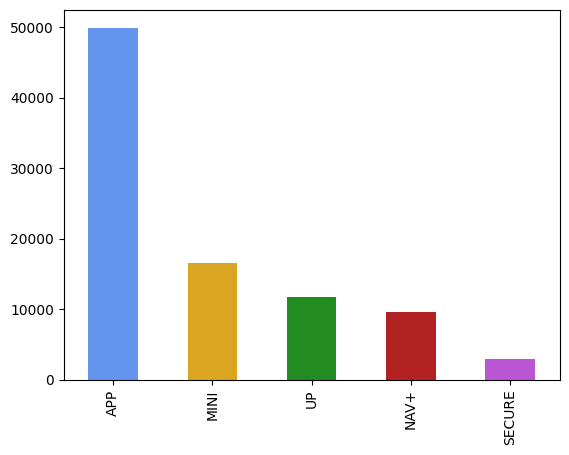

In [5]:
def find_match_count(word: str, pattern: str) -> int:
    return len(re.findall(r"\b{}\b".format(pattern), r"\b{}\b".format(word)))

for col in filter_words:
    crm[col] = crm["comms_clean"].apply(find_match_count, pattern=col)

crm[["UP", "MINI", "NAV+", "APP", "SECURE"]] = np.where(
    crm[["UP", "MINI", "NAV+", "APP", "SECURE"]] != 0,
    1,
    crm[["UP", "MINI", "NAV+", "APP", "SECURE"]],
)

crm[["UP", "MINI", "NAV+", "APP", "SECURE"]].apply(pd.Series.sum).sort_values(
    ascending=False
).plot(
    kind="bar",
    color=["cornflowerblue", "goldenrod", "forestgreen", "firebrick", "mediumorchid"],
);

## Monthly devices occurences

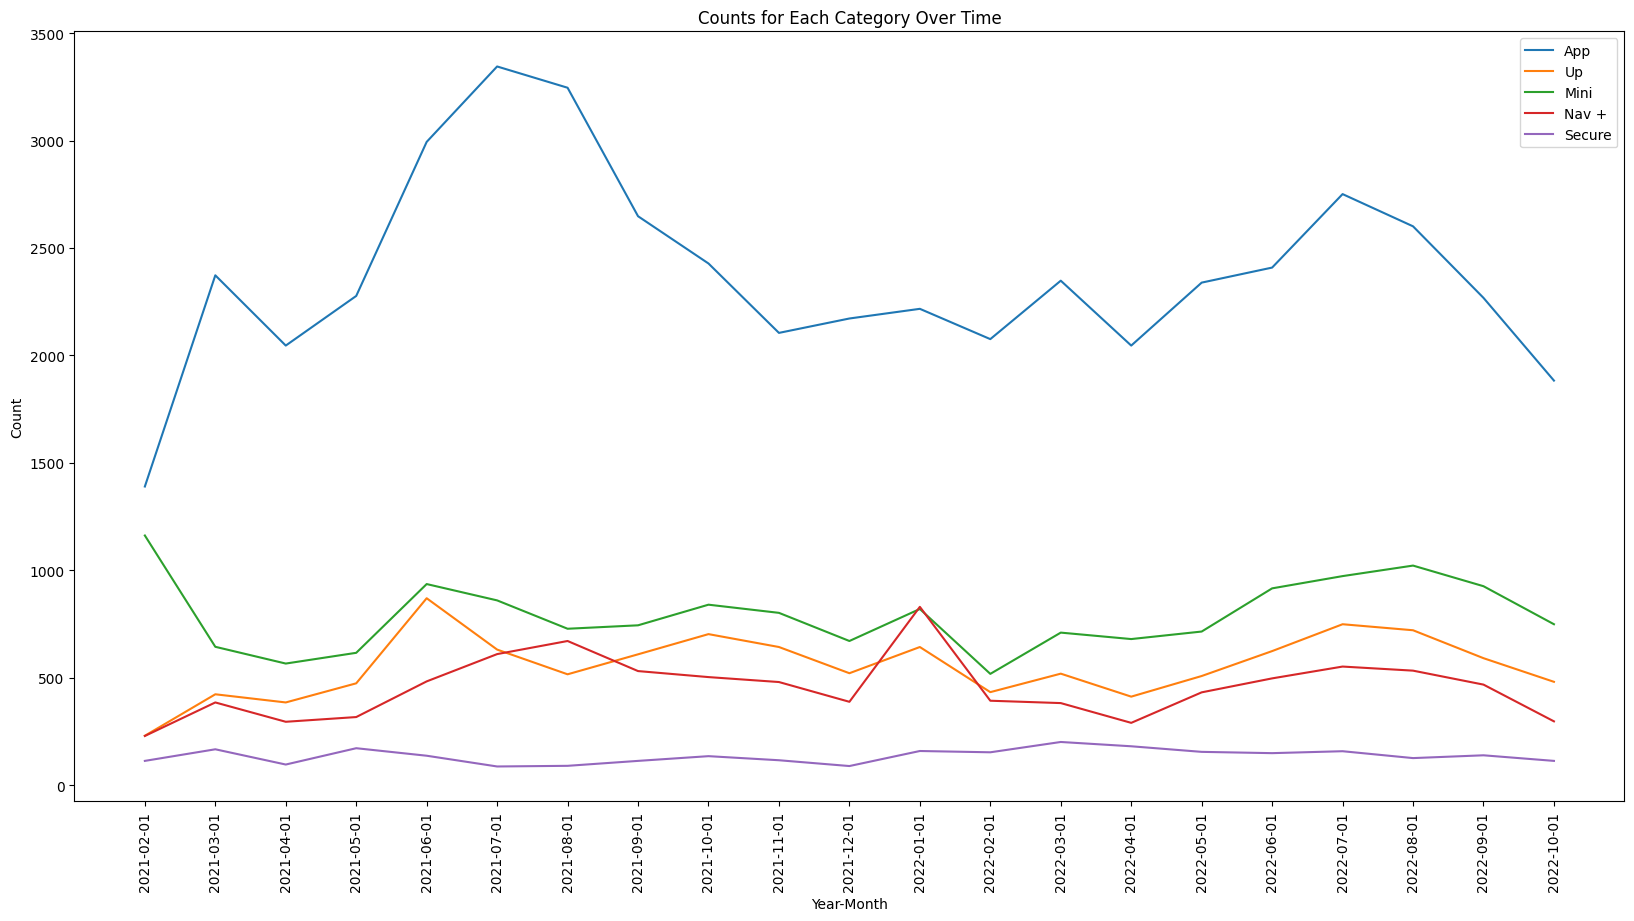

In [6]:
count_each = crm.groupby("year_month")[["UP", "MINI", "NAV+", "APP", "SECURE"]].sum()

plt.figure(figsize=(20, 10))

plt.plot(count_each["APP"], label="App")
plt.plot(count_each["UP"], label="Up")
plt.plot(count_each["MINI"], label="Mini")
plt.plot(count_each["NAV+"], label="Nav +")
plt.plot(count_each["SECURE"], label="Secure")

plt.title("Counts for Each Category Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Count")
plt.legend()

# Rotate x-axis labels vertically
plt.xticks(rotation="vertical")

plt.show()